<image src="https://i.imgur.com/HrRxc5o.jpeg" width=100%>

# <font color='#00FFFF'>**Diferentes técnicas de Segmentación**</font>

### **Importamos librerías y dependencias**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [2]:
from skimage.segmentation import felzenszwalb, slic, mark_boundaries, find_boundaries
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from skimage.util import img_as_float
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from skimage.filters import sobel
from google.colab import files
from PIL import Image
co=255

### **Sube imágenes aquí para explorar los métodos**

In [3]:
uploaded = files.upload()
image_paths = []

for fn in uploaded.keys():
  if not os.path.exists('uploaded_images'):
    os.makedirs('uploaded_images')

  path = os.path.join('uploaded_images', fn)
  image_paths.append(path)

  with open(path, 'wb') as f:
    f.write(uploaded[fn])

  print('User uploaded file "{name}" with length {length} bytes and saved to {path}'.format(
      name=fn, length=len(uploaded[fn]), path=path))

Saving images.jpg to images.jpg
User uploaded file "images.jpg" with length 22121 bytes and saved to uploaded_images/images.jpg


### **Visualización de las imagenes que subimos**

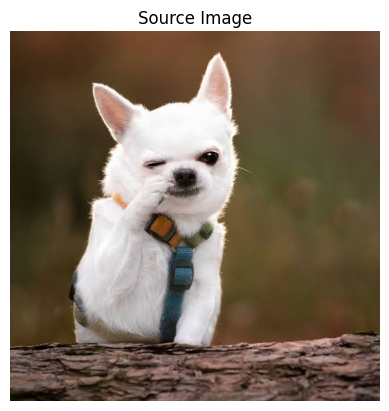

In [4]:
#Cargar imagen de OpenCV
image = cv2.imread(image_paths[0]) # Podemos cambiar la imagen si cambiamos el indice
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis("off")
plt.title("Source Image")
plt.show()

## <font color='#00FFFF'> **1. Clustering** </font>

**K-Means** es un algoritmo de agrupamiento iterativo que busca particionar los datos (en este caso, los píxeles) en `k` clústeres, minimizando la variación dentro de cada clúster.

El Objetico es minimizar la suma de distancias cuadradas entre los puntos y sus centroides:

$$
J = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$$

Donde:
- $C_i$ es el conjunto de puntos asignados al clúster $i$
- $\mu_i$ es el centroide del clúster $i$
- $x $ es un vector RGB de un píxel

El algoritmo lo que hace es:
1. Inicializar `k` centroides (puede ser `random` o usando `k-means++`)
2. Asignar cada punto al centroide más cercano (mínima distancia euclidiana)
3. Recalcular los centroides como la media de los puntos asignados
4. Repetir pasos 2 y 3 hasta que los centroides no cambien significativamente



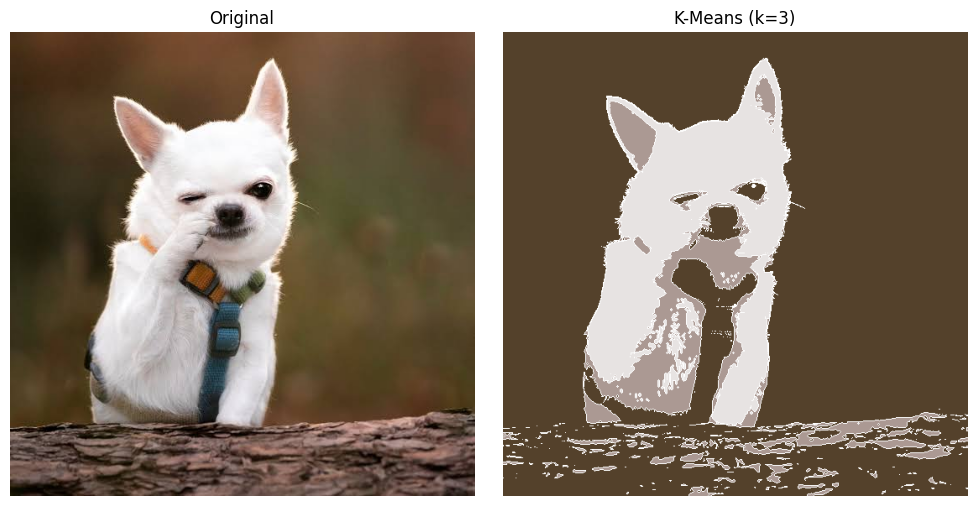

In [10]:
flat_image = image.reshape((-1, 3))

k = 3 # Número de clústeres
kmeans = KMeans(n_clusters=k,init='k-means++', max_iter=100, tol=0.1, random_state=42)
kmeans.fit(flat_image)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
segmented_img = cluster_centers[labels].reshape(image.shape).astype(np.uint8)

# Visualizamos
labels_2d = labels.reshape((image.shape[0], image.shape[1]))
boundaries = find_boundaries(labels_2d, mode='outer')
segmented_with_borders = segmented_img.copy()
segmented_with_borders[boundaries] = co
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(image); plt.title('Original'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(segmented_with_borders); plt.title(f'K-Means (k={k})'); plt.axis('off')
plt.tight_layout()
plt.show()

## <font color='#00FFFF'> **2. Mean-shift** </font>

**Mean-Shift** es un algoritmo de agrupamiento basado en modos de densidad: busca los picos en la distribución de datos sin necesidad de definir `k`.

La idea es mover cada punto hacia la región de mayor densidad local en el espacio de características (en este caso, RGB).

$$
x^{(t+1)} = \frac{\sum_{i} x_i \cdot K\left(\frac{\|x_i - x^{(t)}\|^2}{h^2}\right)}{\sum_{i} K\left(\frac{\|x_i - x^{(t)}\|^2}{h^2}\right)}
$$

Donde:
- $ x^{(t)} $ es la posición actual
- $ x_i$ vecinos de $x^{(t)}$
- $K$ es un kernel (comúnmente Gaussiano)
- $ h $ es el parámetro de **bandwidth** que controla el tamaño de la ventana

El algoritmo lo que hace es:
1. Inicializar cada punto como un centro candidato
2. Iterar sobre cada punto y moverlo hacia la media ponderada de sus vecinos
3. Agrupar puntos que convergen al mismo modo

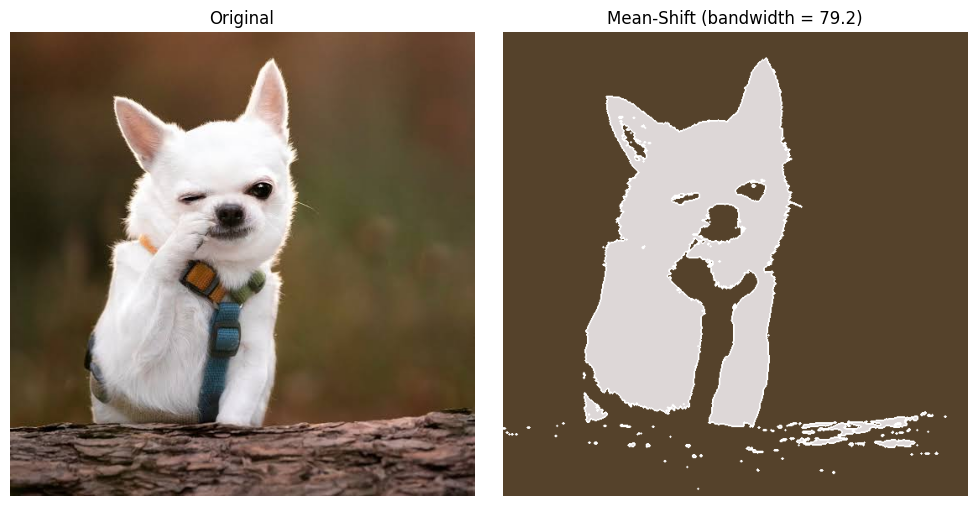

In [11]:
flat_image = image.reshape((-1, 3))

bandwidth = estimate_bandwidth(flat_image, quantile=0.4, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(flat_image)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
segmented_img = cluster_centers[labels].reshape(image.shape).astype(np.uint8)


# Visualizamos
labels_2d = labels.reshape((image.shape[0], image.shape[1]))
boundaries = find_boundaries(labels_2d, mode='thick')
segmented_with_borders = segmented_img.copy()
segmented_with_borders[boundaries] = co
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(image); plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2); plt.imshow(segmented_with_borders)
plt.title(f'Mean-Shift (bandwidth = {bandwidth:.1f})')
plt.axis('off')
plt.tight_layout()
plt.show()

## <font color='#00FFFF'> **3. SLIC (Simple Linear Iterative Clustering)** </font>

**SLIC** genera superpíxeles usando un algoritmo similar a K-Means, pero en un espacio 5D (color + posición). Es eficiente y respeta bien los bordes.

Cada píxel se representa como:

$$[l, a, b, x, y]$$

Donde:
- $( l, a, b )$ son componentes del espacio de color CIELAB (perceptualmente uniforme)
- $( x, y )$ son coordenadas espaciales

El algoritmo calcula la distancia de la forma:
$$
D_s = d_{lab} + \frac{m}{S} d_{xy}
$$

$$
S = \sqrt{\frac{N}{K}}
$$


Donde:
- $d_{lab}$: distancia euclidiana en color
- $ d_{xy}$: distancia espacial
- $m$: Es un parámetro de ponderación que controla la importancia relativa entre el color y el espacio. Valores grandes de $m$ hacen que la segmentación se enfoque más en la proximidad espacial (superpíxeles más compactos), mientras que valores pequeños la hacen más sensible a los cambios de color.
- $N$: es el número total de píxeles en la imagen
- $K$: es el número de superpíxeles deseado

el proceso que se sigue es:
1. Inicializar centroides en una cuadrícula regular
2. Para cada píxel en una vecindad local, asignar al centroide más cercano según `D`
3. Recalcular centroides
4. Repetir hasta convergencia


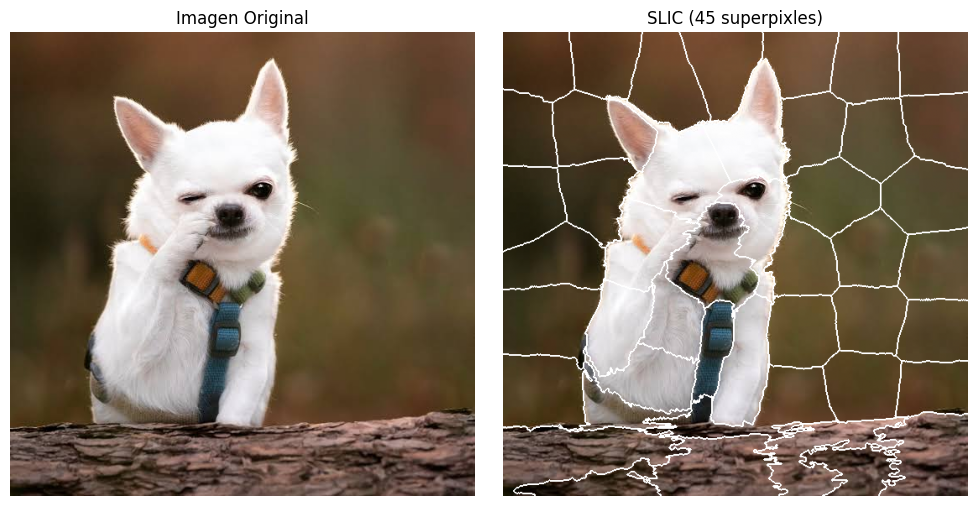

In [20]:
K = 50
m = 20
segments_slic = slic(image, n_segments=K, compactness=m)

# Visualizamos el resultado
fig, axes = plt.subplots(1, 2, figsize=(10, 5));
axes[0].imshow(image);
axes[0].axis("off")
axes[0].set_title("Imagen Original")
axes[1].imshow(mark_boundaries(image, segments_slic, color=1));
axes[1].axis("off")
axes[1].set_title(f"SLIC ({len(np.unique(segments_slic))} superpixles)")
plt.tight_layout()
plt.show()

## <font color='#00FFFF'> **4. Graph-based** </font>

El algoritmo de **Felzenszwalb-Huttenlocher** modela la imagen como un grafo, donde los nodos son píxeles y las aristas conectan píxeles vecinos con pesos basados en la diferencia de color.


La idea es segmentar la imagen maximizando la homogeneidad dentro de las regiones y los contrastes en los bordes.

Cada peso lo definimos como:
$$
w(u, v) = \|I(u) - I(v)\|
$$

Donde:
- $I(u), I(v)$: intensidad o color de los píxeles $u$ y $v$

Se unen regiones $A$ y $B$ si:

$$
w(A, B) \leq \min(\text{Int}(A) + \tau(A), \text{Int}(B) + \tau(B))
$$
$$
$$

$$ \tau(A) = k / |A| $$
Donde:
- $ \text{Int}(A) $: variación interna de A
- $\tau(A)$ : función que penaliza regiones pequeñas (k es un parámetro de escala)

El proceso se realiza como:
1. Crear grafo con aristas entre píxeles vecinos
2. Ordenar aristas por peso
3. Unir componentes si cumplen el criterio de umbral
4. Opcionalmente eliminar regiones pequeñas

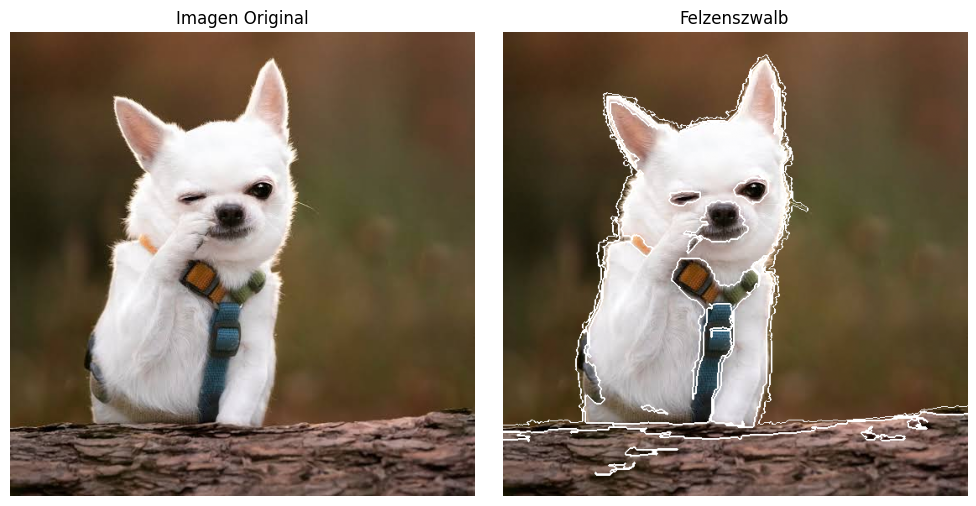

In [25]:
k=1000
r=100
segments_fz = felzenszwalb(image, scale=k, min_size=r)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Imagen Original")
ax[1].imshow(mark_boundaries(image, segments_fz, color=1))
ax[1].set_title(f"Felzenszwalb")
for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout()
plt.show()

## <font color='#00FFFF'> **Bibliografía** </font>

(N.d.). KDnuggets. Retrieved May 4, 2025, from https://www.kdnuggets.com/2019/08/introduction-image-segmentation-k-means-clustering.html

Comaniciu, D., & Meer, P. (2002). Mean shift: A robust approach toward feature space analysis. IEEE Transactions on pattern analysis and machine intelligence, 24(5), 603-619.

Felzenszwalb, P. F., & Huttenlocher, D. P. (2004). Efficient graph-based image segmentation. International journal of computer vision, 59, 167-181.

Achanta, R., Shaji, A., Smith, K., Lucchi, A., Fua, P., & Süsstrunk, S. (2010). Slic superpixels.

GeeksforGeeks. (2024, July 10). Image segmentation using mean shift clustering. GeeksforGeeks. https://www.geeksforgeeks.org/image-segmentation-using-mean-shift-clustering/